# 決定木から始める機械学習

In [1]:
try:
    import category_encoders
    import graphviz
except:
    !pip install graphviz
    !pip install category_encoders

In [2]:
# 表形式のデータを操作するためのライブラリ
import pandas as pd

# 機械学習用ライブラリsklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz

# その他
import category_encoders

# グラフ描画ライブラリ
from graphviz import Source
import matplotlib.pyplot as plt
%matplotlib inline


---

## クイズ

以下のコードを実行して`income_df`に格納されるデータは，ある年にアメリカで実施された国勢調査のデータである．

In [3]:
# データの読み込み
income_df = pd.read_table("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", sep=',', header=None)

# 列名（特徴）に名前を付ける
income_df.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 
                     'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

# データ表示（先頭5件）
income_df.head()

age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  income  
0          2174             0              40   United-States   <=50K  
1             0             0              13   United-States   <=50K  
2             0             0              40   United-States   <=50K  
3             0             0              40   United-States   <=50K  
4             0             0              40            Cuba   <=50K

データ中の列名（特徴量）の意味は以下の通りである：

* age: 年齢（整数）
* workclass: 雇用形態（公務員，会社員など）
* fnlwgt: 使わない
* education: 学歴
* education-num: 使わない
* marital-status: 婚姻状態
* occupation: 職業
* relationship: 家族内における役割
* race: 人種
* sex: 性別
* capital-gain: 使わない
* capital-loss: 使わない
* hours-per-week: 週あたりの労働時間（整数値）
* native-country: 出身国
* income: 年収（50Kドル以上，50Kドル未満の二値）

このデータに対して決定木アルゴリズムを適用して，ある人物が年間収入が50Kドル以上か未満かを分類する機械学習モデルを構築したい．

(L2-Q1)=
### Q1: ヒストグラム 
機械学習モデルを構築する前に，`income_df`データに含まれる調査対象者の年齢の分布を知りたい．
年齢に関するヒストグラム（階級数は10）を作成せよ．

※ ヒント: ヒストグラムの作成には`pandas.series.hist`関数を用いるとよい（[参考](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html)）

<AxesSubplot:>

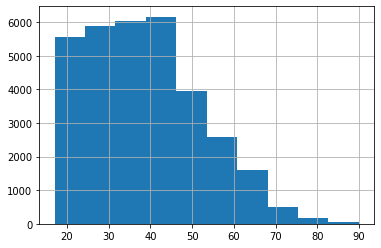

In [4]:
income_df['age'].hist(bins=10)

(L2-Q2)=
### Q2: 出現頻度
機械学習モデルを構築する前に，`income_df`データに含まれる性別，年収の分布を知りたい．
性別（男，女），年収（50K以上，50K未満）について，属性値に対応する人数を求めよ．

※ ヒント: 要素の出現頻度を求めるには`pandas.series.value_counts`メソッドを用いるとよい（[参考](https://note.nkmk.me/python-pandas-value-counts/)）

In [5]:
income_df['sex'].value_counts()

 Male      21790
 Female    10771
Name: sex, dtype: int64

In [6]:
income_df['income'].value_counts()

 <=50K    24720
 >50K      7841
Name: income, dtype: int64

(L2-Q3)=
### Q3: データの集約
``income_df``データを集約し，学歴ごとに年間収入クラスの内訳（割合）を調べよ．

※ ヒント: pandasの[crosstab](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html)関数を使う（タイタニックの例でも使ったので，確認してみよう）

In [7]:
pd.crosstab(income_df['education'], income_df['income'], normalize='index')

income            <=50K      >50K
education                        
 10th          0.933548  0.066452
 11th          0.948936  0.051064
 12th          0.923788  0.076212
 1st-4th       0.964286  0.035714
 5th-6th       0.951952  0.048048
 7th-8th       0.938080  0.061920
 9th           0.947471  0.052529
 Assoc-acdm    0.751640  0.248360
 Assoc-voc     0.738784  0.261216
 Bachelors     0.585247  0.414753
 Doctorate     0.259080  0.740920
 HS-grad       0.840491  0.159509
 Masters       0.443413  0.556587
 Preschool     1.000000  0.000000
 Prof-school   0.265625  0.734375
 Some-college  0.809765  0.190235

(L2-Q4)=
### Q4: 学習のためのデータ分割
`income_df`データに決定木アルゴリズムを適用するために，データを7:3に分割し，7割のデータを学習用データ（`income_train_df`），3割のデータを評価用データ（`income_test_df`）としなさい．

In [8]:
# データを学習用（70%）と評価用（30%）に分割する
income_train_df, income_test_df = train_test_split(
                                income_df,
                                test_size=0.3,
                                random_state=1,
                                stratify=income_df.income)

(L2-Q5)=
### Q5: 決定木の構築

以下は，「年齢」「雇用形態」「学歴」「婚姻の有無」「職業」「家族内における役割」「人種」「性別」「週あたりの労働時間」「出身国」の属性に着目して，`income_df`データから年収カテゴリを予測する決定木を構築するコードである．
`# ---------- ` の間を埋めてコードを完成させなさい．

In [9]:
# 注目する属性
target_features = ['age', 'workclass', 'education', 'marital-status', 'occupation', 
                   'relationship', 'race', 'sex', 'hours-per-week', 'native-country']

# 数値に変換したいカテゴリ変数
encoded_features = ['education', 'workclass', 'marital-status', 'relationship', 'occupation', 'native-country', 'race', 'sex']

# カテゴリ変数を数値情報に変換する
encoder = category_encoders.OneHotEncoder(cols=encoded_features, use_cat_names=True)
encoder.fit(income_train_df[target_features])

# ---------------------
# ここから必要なコードを埋める

# 予測に用いる年収情報以外のすべての指標をX_trainに
X_train = income_train_df[target_features]

# カテゴリ変数を数値情報に変換
X_train = encoder.transform(X_train)

# y_trainは年収クラスをあらわす指標
y_train = income_train_df.income

# 学習器の定義（決定木を使う）
model = DecisionTreeClassifier(criterion='entropy',
                               max_depth=5)

# ここまで必要なコードを埋める
# ---------------------

# 学習用データを使って学習
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

(L2-Q6)=
### Q6: 決定木における各属性の寄与度
構築した決定木モデル（`model`）を用いて，年収（`income`）の分類における各属性（列）の寄与度を表示しなさい．
なお，寄与度がゼロのものは表示しなくてよい．

In [10]:
for feature, importance in zip(X_train.columns, model.feature_importances_):
    if importance > 0:
        print("{}\t{}".format(feature, importance))

age	0.0894604682456178
workclass_ State-gov	0.000640985686209342
education_ Bachelors	0.06141563902135156
education_ Some-college	0.006168600381132655
education_ Prof-school	0.003625407861733974
education_ HS-grad	0.00881490359411402
education_ Masters	0.010774717032624306
marital-status_ Married-civ-spouse	0.5943231227829802
occupation_ Prof-specialty	0.07941724495727506
occupation_ Exec-managerial	0.0643690097067649
occupation_ Protective-serv	0.0011395499411790816
sex_ Male	0.0020402074457221034
sex_ Female	0.0020803940555122083
hours-per-week	0.07499207892598281
native-country_ Portugal	0.0007376703617999955


(L2-Q7)=
### Q7: 決定木の再構築
Q6の結果をもとに年収分類に寄与する特徴量を（最大5つ）特定し，その特徴量のみを用いて再度決定木モデルを構築しなさい．
その際，あまり木が深くならないよう調整し，できる限りシンプルなモデルになるようにすること．

In [11]:
target_features = ['age', 'education', 'marital-status', 'occupation', 'hours-per-week']
encoded_features = ['education', 'marital-status', 'occupation']

encoder = category_encoders.OneHotEncoder(cols=encoded_features, use_cat_names=True)
encoder.fit(income_train_df[target_features])

X_train = income_train_df[target_features]
X_train = encoder.transform(X_train)
y_train = income_train_df.income

# 学習
model = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

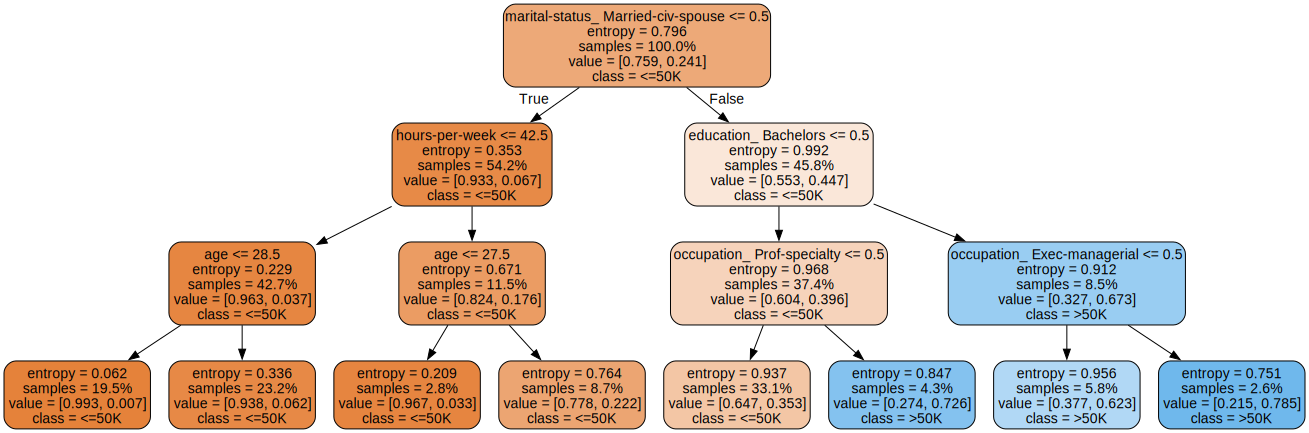

In [12]:
Source(export_graphviz(
    model, out_file=None,
    feature_names=X_train.columns,
    class_names=['<=50K', '>50K'],
    proportion=True,
    filled=True, rounded=True # 見た目の調整
))